In [50]:
import numpy as np 
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load an individual data file

Shape is (N x 78) - where 78 is a fixed value, N is the number of frames

In [51]:
train_fn = ['C56D', 'C93D', 'C382D', 'C382N', 'C544D', 'C709N', 'C788N', 'P113D', 'P113N', 'P191D', 'P191N', 'P299D', 'P300D', 'P336D', 'P492D', 'P492N', 'P531N', 'P699D', 'P699N', 'P890N', 'P921D', 'P921N']

data = []
# Load all train files
for i in range(len(train_fn)):
    name = train_fn[i]
    matFile = loadmat('./emo_data/train/' + name + '.mat')
    matFile.keys()
    data.append(matFile['data'])

# Note the second dimension for every file has a different length
data = np.array(data)
print(data.shape)

(22,)


In [52]:
# X coordinates of 1st person 22 body joints
X_coords = data[0][:, 0:22]
# Y coordinates of 1st person 22 body joints
Y_coords = data[0][:, 22:44]
# Z coordinates of 1st person 22 body joints
Z_coords = data[0][:, 44:66]

print(X_coords.shape)

(13334, 22)


## Some common graph functions

In [53]:
# Plot a single block of coordinate data
# Input: data (NxM)
def plot_single_line_coord_block(data):
    dims = data.shape[1]
    print('DIMS ', dims)
    for i in range(dims):
        plt.plot(data[:, i])
        
    return plt.show()

# Plot all three coordinate blocks together
def plot_all_coords(X, Y, Z):
    dims = X.shape[1]
    for i in range(dims):
        plt.plot(X[:, i], color='blue')
        plt.plot(Y[:, i], color='green')
        plt.plot(Z[:, i], color='red')
        
    plt.xlabel('Frames')
    plt.ylabel('Coordindate Position')
    plt.title('Coordinate data (Blue - X, Green - Y, Red - Z)')
    return plt.show()

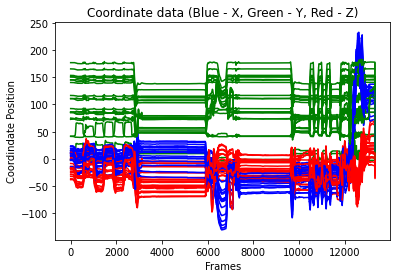

In [54]:
plot_all_coords(X_coords, Y_coords, Z_coords)

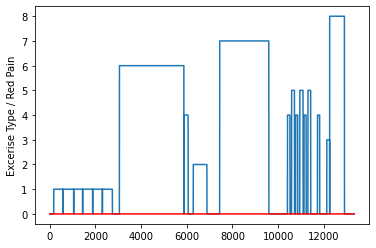

In [55]:
plt.plot(data[0][:, 70])
plt.plot(data[0][:, 71], color = 'red')
plt.ylabel('Excerise Type / Red Pain')
plt.show()

In [101]:
def format_single_person_coords(single_data_item):
    SW_LENGTH = int(180 - (180 * 0.5)) # 3 seconds + 50% overlap
    new_data = []
    new_data_labels = []

    count = 0
    start = 0
    end = start + SW_LENGTH
    T = single_data_item.shape[0]

    while start < T:
        currentCoords = single_data_item[start:end, 0:66]
        behaviours = np.array(single_data_item[start:end, 72]).astype('int64')
        
        majority_protective_behaviour = np.argmax(np.bincount(behaviours))
        A, B = currentCoords.shape
        if A < 180:
            # We need to pad
            currentCoords = np.pad(currentCoords, ((0, 180 - A), (0, 0)))

        new_data.append(currentCoords)
        new_data_labels.append(majority_protective_behaviour)

        # Update pointers
        count += 1
        start += SW_LENGTH
        end = start + SW_LENGTH

    new_data = np.array(new_data)
    new_data_labels = np.array(new_data_labels)
    print(new_data.shape)
    print(new_data_labels.shape)
    
    return new_data, new_data_labels

# Example
new_data, new_data_labels = format_single_person_coords(data[9])

(174, 180, 66)
(174,)


In [102]:
class LSTM(nn.Module):
    def __init__(self, input_size=66, hidden_layer_size=66, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        # LSTM hidden cell
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

        # Conv Layer
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.linear1 = nn.Linear(1 * 16 * 2 * 42, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, output_size)
        
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        lstm_out = lstm_out.view(len(input_seq), -1)
        
        lstm_conv_shape = torch.reshape(lstm_out, (180, 22, 3))
        lstm_conv_shape = torch.transpose(lstm_conv_shape, 0, 2)
        conv_shape = lstm_conv_shape.unsqueeze(0)
        #print(lstm_conv_shape.shape)
        #print(conv_shape.shape)
        
        # print(lstm_conv_shape.detach().numpy()[0].shape)
        # print(lstm_conv_shape.detach().numpy().T.shape)
        # plot_single_line_coord_block(lstm_conv_shape.detach().numpy()[0])
        # print(F.relu(self.conv1(lstm_conv_shape.unsqueeze(0))).shape)
        
        x = self.pool(F.relu(self.conv1(conv_shape)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return x

In [103]:
model = LSTM()
print(model)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(new_data.shape[0]):
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))

    _data = torch.Tensor(new_data[i])
    _label = torch.Tensor([new_data_labels[i]])

    pred = model(_data)
    loss = loss_function(pred, _label)
    loss.backward()
    optimizer.step()
    
    print('Loss, ', loss.item())

LSTM(
  (lstm): LSTM(66, 66)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=1344, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (linear): Linear(in_features=66, out_features=1, bias=True)
)
Loss,  0.004192701540887356
Loss,  0.04769936949014664
Loss,  0.00201424746774137
Loss,  0.002304685302078724
Loss,  0.007129133678972721
Loss,  0.007629322819411755
Loss,  0.005536878947168589
Loss,  0.002992400899529457
Loss,  0.0011325980303809047
Loss,  0.00017760561604518443
Loss,  3.234178075217642e-05
Loss,  0.0004827943630516529
Loss,  0.0010869966354221106
Loss,  0.0013432127889245749
Loss,  0.0008956953533925116
Loss,  0.0008349656709469855
Loss,  0.0003186601388733834
Loss,  8.627300121588632

### 

In [ ]:
q